In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
from pathlib import Path



# Load processed data
print("\nLoading processed datasets...")
train_df = pd.read_csv('data/processed/train.csv')
val_masked = pd.read_csv('data/processed/val_masked.csv')
test_masked = pd.read_csv('data/processed/test_masked.csv')

print(f"   Train: {train_df.shape}")
print(f"   Val:   {val_masked.shape}")
print(f"   Test:  {test_masked.shape}")

# Load ground truth
with open('data/processed/val_ground_truth.pkl', 'rb') as f:
    val_ground_truth = pickle.load(f)

with open('data/processed/test_ground_truth.pkl', 'rb') as f:
    test_ground_truth = pickle.load(f)

print(f"\n   Val ground truth: {len(val_ground_truth):,} values")
print(f"   Test ground truth: {len(test_ground_truth):,} values")

# Load metadata
with open('data/processed/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

features_to_scale = metadata['features_to_scale']
print(f"\n  Features to impute: {len(features_to_scale)}")

print("\nAll data loaded successfully")


Loading processed datasets...
   Train: (37200, 147)
   Val:   (8000, 147)
   Test:  (7999, 147)

   Val ground truth: 44,020 values
   Test ground truth: 43,669 values

  Features to impute: 50

All data loaded successfully


In [2]:

print("STEP 2: CREATE EVALUATION FUNCTION")


def evaluate_imputation(df_imputed, ground_truth, dataset_name, method_name):


    y_true = []
    y_pred = []
    
    # Extract predictions and ground truth
    for (idx, feature), true_val in ground_truth.items():
        pred_val = df_imputed.loc[idx, feature]
        
        # Only use if both are valid numbers
        if pd.notna(pred_val) and pd.notna(true_val):
            y_true.append(true_val)
            y_pred.append(pred_val)
    
    # Convert to arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
    
    # Print results
    print(f"\n{method_name} - {dataset_name}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Evaluated on: {len(y_true):,} values")
    
    return {
        'method': method_name,
        'dataset': dataset_name,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'n_values': len(y_true)
    }

print("\n Evaluation function created")

STEP 2: CREATE EVALUATION FUNCTION

 Evaluation function created


In [3]:

print("BASELINE 1: FORWARD-FILL + BACKWARD-FILL")

def forward_backward_fill(df, features):
    """
    Fill missing values by propagating forward, then backward
    """
    df_filled = df.copy()
    
    for feature in features:
        # Forward fill (propagate last observation forward)
        df_filled[feature] = df_filled[feature].fillna(method='ffill')
        
        # Backward fill (propagate next observation backward)
        df_filled[feature] = df_filled[feature].fillna(method='bfill')
    
    return df_filled

# Apply to validation set
print("\nApplying to validation set...")
val_ffill = forward_backward_fill(val_masked, features_to_scale)

# Check if all NaNs filled
remaining_nans = val_ffill[features_to_scale].isnull().sum().sum()
print(f"  Remaining NaNs: {remaining_nans:,}")

if remaining_nans > 0:
    print("  ⚠️  Some NaNs remain (features entirely missing)")
    # Fill remaining with 0
    for feature in features_to_scale:
        if val_ffill[feature].isnull().any():
            val_ffill[feature] = val_ffill[feature].fillna(0)
    print("  ✓ Filled remaining NaNs with 0")

# Evaluate
val_ffill_results = evaluate_imputation(
    val_ffill, 
    val_ground_truth, 
    'Validation', 
    'Forward-Backward Fill'
)

# Apply to test set
print("\nApplying to test set...")
test_ffill = forward_backward_fill(test_masked, features_to_scale)

remaining_nans = test_ffill[features_to_scale].isnull().sum().sum()
if remaining_nans > 0:
    for feature in features_to_scale:
        if test_ffill[feature].isnull().any():
            test_ffill[feature] = test_ffill[feature].fillna(0)

# Evaluate
test_ffill_results = evaluate_imputation(
    test_ffill, 
    test_ground_truth, 
    'Test', 
    'Forward-Backward Fill'
)

print("\n Forward-Backward Fill complete")

BASELINE 1: FORWARD-FILL + BACKWARD-FILL

Applying to validation set...
  Remaining NaNs: 0


C:\Users\Aditya\AppData\Local\Temp\ipykernel_44572\3540769984.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[feature] = df_filled[feature].fillna(method='ffill')
C:\Users\Aditya\AppData\Local\Temp\ipykernel_44572\3540769984.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[feature] = df_filled[feature].fillna(method='bfill')



Forward-Backward Fill - Validation
  RMSE: 3.7082
  MAE:  0.2396
  MAPE: 4614214.89%
  Evaluated on: 44,020 values

Applying to test set...


C:\Users\Aditya\AppData\Local\Temp\ipykernel_44572\3540769984.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[feature] = df_filled[feature].fillna(method='ffill')
C:\Users\Aditya\AppData\Local\Temp\ipykernel_44572\3540769984.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[feature] = df_filled[feature].fillna(method='bfill')



Forward-Backward Fill - Test
  RMSE: 1.3507
  MAE:  0.1958
  MAPE: 5561534.70%
  Evaluated on: 43,669 values

 Forward-Backward Fill complete


In [4]:

print("BASELINE 2: LINEAR INTERPOLATION")


def linear_interpolation(df, features):
    """
    Fill missing values using linear interpolation
    """
    df_filled = df.copy()
    
    for feature in features:
        # Linear interpolation
        df_filled[feature] = df_filled[feature].interpolate(
            method='linear',
            limit_direction='both'  # Interpolate and extrapolate
        )
        
        # If still NaN (entire column missing), fill with 0
        if df_filled[feature].isnull().any():
            df_filled[feature] = df_filled[feature].fillna(0)
    
    return df_filled

# Apply to validation set
print("\nApplying to validation set...")
val_interp = linear_interpolation(val_masked, features_to_scale)

# Evaluate
val_interp_results = evaluate_imputation(
    val_interp,
    val_ground_truth,
    'Validation',
    'Linear Interpolation'
)

# Apply to test set
print("\nApplying to test set...")
test_interp = linear_interpolation(test_masked, features_to_scale)

# Evaluate
test_interp_results = evaluate_imputation(
    test_interp,
    test_ground_truth,
    'Test',
    'Linear Interpolation'
)

print("\n Linear Interpolation complete")


BASELINE 2: LINEAR INTERPOLATION

Applying to validation set...

Linear Interpolation - Validation
  RMSE: 2.8568
  MAE:  0.1687
  MAPE: 4499350.21%
  Evaluated on: 44,020 values

Applying to test set...

Linear Interpolation - Test
  RMSE: 1.1379
  MAE:  0.1501
  MAPE: 3919944.84%
  Evaluated on: 43,669 values

 Linear Interpolation complete


In [5]:

print("BASELINE 3: KNN IMPUTATION")



def knn_imputation(df, features, n_neighbors=5):
    """
    Fill missing values using K-Nearest Neighbors
    """
    df_filled = df.copy()
    
    # KNN Imputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    
    # Apply imputation
    print(f"  Running KNN with k={n_neighbors}...")
    df_filled[features] = imputer.fit_transform(df[features])
    
    return df_filled

# Apply to validation set
print("\nApplying to validation set (this will take time)...")
val_knn = knn_imputation(val_masked, features_to_scale, n_neighbors=5)

# Evaluate
val_knn_results = evaluate_imputation(
    val_knn,
    val_ground_truth,
    'Validation',
    'KNN (k=5)'
)

# Apply to test set
print("\nApplying to test set (this will take time)...")
test_knn = knn_imputation(test_masked, features_to_scale, n_neighbors=5)

# Evaluate
test_knn_results = evaluate_imputation(
    test_knn,
    test_ground_truth,
    'Test',
    'KNN (k=5)'
)

print("\n KNN Imputation complete")

BASELINE 3: KNN IMPUTATION

Applying to validation set (this will take time)...
  Running KNN with k=5...

KNN (k=5) - Validation
  RMSE: 3.7305
  MAE:  0.3334
  MAPE: 36549718.69%
  Evaluated on: 44,020 values

Applying to test set (this will take time)...
  Running KNN with k=5...

KNN (k=5) - Test
  RMSE: 1.0840
  MAE:  0.2551
  MAPE: 39445190.92%
  Evaluated on: 43,669 values

 KNN Imputation complete


In [6]:

print("BASELINE COMPARISON")

# Collect all results
all_results = [
    val_ffill_results,
    test_ffill_results,
    val_interp_results,
    test_interp_results,
    val_knn_results,
    test_knn_results,
]

# Create summary dataframe
results_df = pd.DataFrame(all_results)

print("\nAll Results:")
print(results_df.to_string(index=False))

# Pivot for better display

print("SUMMARY TABLE")


# Create comparison table
comparison = results_df.pivot_table(
    index='method',
    columns='dataset',
    values=['rmse', 'mae']
)

print("\n", comparison.to_string())

# Save results
Path('../results').mkdir(exist_ok=True)
results_df.to_csv('../results/baseline_results.csv', index=False)
print("\n Results saved to results/baseline_results.csv")

# Find best method

print("BEST METHODS")


val_results = results_df[results_df['dataset'] == 'Validation']
test_results = results_df[results_df['dataset'] == 'Test']

print("\nValidation Set (by RMSE):")
best_val = val_results.loc[val_results['rmse'].idxmin()]
print(f"  Best: {best_val['method']}")
print(f"  RMSE: {best_val['rmse']:.4f}")
print(f"  MAE:  {best_val['mae']:.4f}")

print("\nTest Set (by RMSE):")
best_test = test_results.loc[test_results['rmse'].idxmin()]
print(f"  Best: {best_test['method']}")
print(f"  RMSE: {best_test['rmse']:.4f}")
print(f"  MAE:  {best_test['mae']:.4f}")


print("KEY FINDINGS")

print(f"\n1. Best baseline method: {best_test['method']}")
print(f"   - Test RMSE: {best_test['rmse']:.4f}")


print(f"\n2. Performance range:")
print(f"   - Worst:  {test_results['rmse'].max():.4f} RMSE")
print(f"   - Best:   {test_results['rmse'].min():.4f} RMSE")
print(f"   - Spread: {(test_results['rmse'].max() - test_results['rmse'].min()):.4f}")



BASELINE COMPARISON

All Results:
               method    dataset     rmse      mae         mape  n_values
Forward-Backward Fill Validation 3.708164 0.239587 4.614215e+06     44020
Forward-Backward Fill       Test 1.350655 0.195772 5.561535e+06     43669
 Linear Interpolation Validation 2.856830 0.168730 4.499350e+06     44020
 Linear Interpolation       Test 1.137913 0.150076 3.919945e+06     43669
            KNN (k=5) Validation 3.730512 0.333438 3.654972e+07     44020
            KNN (k=5)       Test 1.083957 0.255110 3.944519e+07     43669
SUMMARY TABLE

                             mae                 rmse           
dataset                    Test Validation      Test Validation
method                                                         
Forward-Backward Fill  0.195772   0.239587  1.350655   3.708164
KNN (k=5)              0.255110   0.333438  1.083957   3.730512
Linear Interpolation   0.150076   0.168730  1.137913   2.856830

 Results saved to results/baseline_results.csv


VISUALIZATION


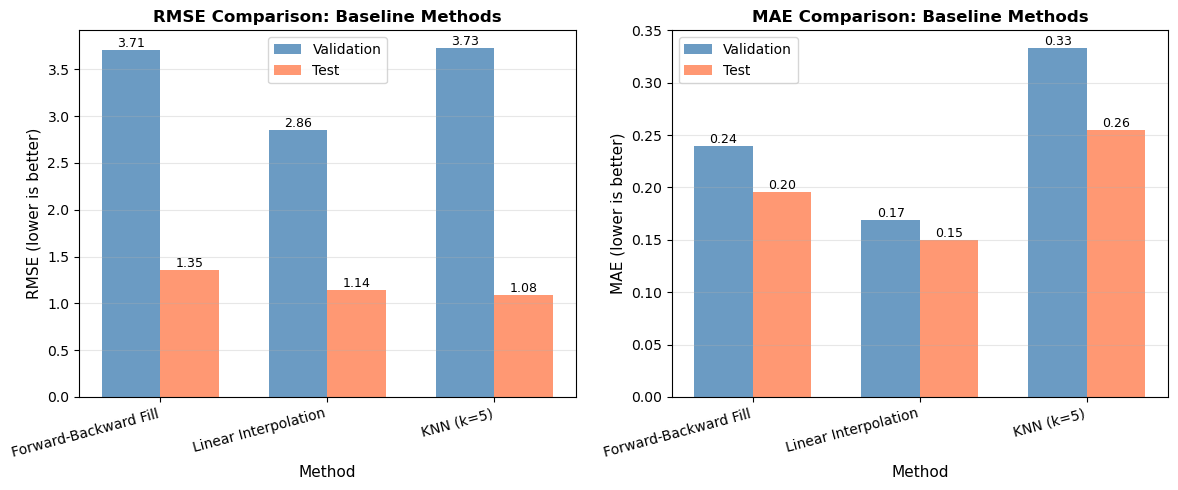


 Figure saved to figures/baseline_comparison.png


In [7]:

print("VISUALIZATION")


# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: RMSE Comparison
ax1 = axes[0]
val_data = results_df[results_df['dataset'] == 'Validation']
test_data = results_df[results_df['dataset'] == 'Test']

x = np.arange(len(val_data))
width = 0.35

bars1 = ax1.bar(x - width/2, val_data['rmse'], width, label='Validation', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, test_data['rmse'], width, label='Test', alpha=0.8, color='coral')

ax1.set_xlabel('Method', fontsize=11)
ax1.set_ylabel('RMSE (lower is better)', fontsize=11)
ax1.set_title('RMSE Comparison: Baseline Methods', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(val_data['method'], rotation=15, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

# Plot 2: MAE Comparison
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, val_data['mae'], width, label='Validation', alpha=0.8, color='steelblue')
bars4 = ax2.bar(x + width/2, test_data['mae'], width, label='Test', alpha=0.8, color='coral')

ax2.set_xlabel('Method', fontsize=11)
ax2.set_ylabel('MAE (lower is better)', fontsize=11)
ax2.set_title('MAE Comparison: Baseline Methods', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(test_data['method'], rotation=15, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Save figure

plt.savefig('figure/baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved to figures/baseline_comparison.png")